In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
import warnings

import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
from jax import random
from matplotlib import rcParams  # type: ignore

from jaxcmr.fitting import ScipyDE as fitting_method
from jaxcmr.helpers import (
    generate_trial_mask,
    import_from_string,
    load_data,
    save_dict_to_hdf5,
)
from jaxcmr.likelihood import MemorySearchLikelihoodFnGenerator as loss_fn_generator
from jaxcmr import repetition
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.summarize import summarize_parameters

warnings.filterwarnings("ignore")

## Setup

In [2]:
# repeat params
allow_repeated_recalls = False
filter_repeated_recalls = False
data_tag = "LohnasKahana2014"
data_path = "data/LohnasKahana2014.h5"

# data params
trial_query = "data['list_type'] > 0"
run_tag = "full_best_of_3"

# fitting params
redo_fits = True
model_factory_path = "jaxcmr.models_repfr.weird_cmr.BaseCMRFactory"
model_name = "WeirdCMR"
relative_tolerance = 0.001
popsize = 15
num_steps = 1000
cross_rate = 0.9
diff_w = 0.85
best_of = 3
target_dir = "projects/thesis"

# sim params
redo_sims = True
seed = 0
experiment_count = 50

# figure params
redo_figures = True

parameters = {
    "fixed": {
    },
    "free": {
        "encoding_drift_rate": [2.220446049250313e-16, 0.9999999999999998],
        "start_drift_rate": [2.220446049250313e-16, 0.9999999999999998],
        "recall_drift_rate": [2.220446049250313e-16, 0.9999999999999998],
        "shared_support": [2.220446049250313e-16, 99.9999999999999998],
        "item_support": [2.220446049250313e-16, 99.9999999999999998],
        "learning_rate": [2.220446049250313e-16, 0.9999999999999998],
        "primacy_scale": [2.220446049250313e-16, 99.9999999999999998],
        "primacy_decay": [2.220446049250313e-16, 99.9999999999999998],
        "stop_probability_scale": [2.220446049250313e-16, 0.9999999999999998],
        "stop_probability_growth": [2.220446049250313e-16, 9.9999999999999998],
        "choice_sensitivity": [2.220446049250313e-16, 99.9999999999999998],
    },
}

single_analysis_paths = [
    "jaxcmr.analyses.repcrp.plot_rep_crp",
    "jaxcmr.analyses.backrepcrp.plot_back_rep_crp",
]

comparison_analysis_paths = [
    "jaxcmr.analyses.spc.plot_spc",
    "jaxcmr.analyses.crp.plot_crp",
    "jaxcmr.analyses.pnr.plot_pnr",
    "jaxcmr.analyses.repneighborcrp.plot_repneighborcrp_i2j",
    "jaxcmr.analyses.repneighborcrp.plot_repneighborcrp_j2i",
    "jaxcmr.analyses.repneighborcrp.plot_repneighborcrp_both",
    "jaxcmr.analyses.rpl.plot_rpl",
    "jaxcmr.analyses.rpl.plot_full_rpl",
]

In [3]:
# Parameters
allow_repeated_recalls = False
filter_repeated_recalls = True
data_tag = "BroitmanKahana2024"
data_path = "data/BroitmanKahana2024.h5"
base_data_tag = "BroitmanKahana2024"
trial_query = "data['subject'] != -1"
model_name = "WeirdNoReinstateCMR"
model_factory_path = "jaxcmr.models_repfr.weird_no_reinstate_cmr.BaseCMRFactory"
redo_fits = False
redo_sims = False
redo_figures = False
parameters = {"fixed": {}, "free": {"encoding_drift_rate": [2.220446049250313e-16, 0.9999999999999998], "start_drift_rate": [2.220446049250313e-16, 0.9999999999999998], "recall_drift_rate": [2.220446049250313e-16, 0.9999999999999998], "shared_support": [2.220446049250313e-16, 100.0], "item_support": [2.220446049250313e-16, 100.0], "learning_rate": [2.220446049250313e-16, 0.9999999999999998], "primacy_scale": [2.220446049250313e-16, 100.0], "primacy_decay": [2.220446049250313e-16, 100.0], "stop_probability_scale": [2.220446049250313e-16, 0.9999999999999998], "stop_probability_growth": [2.220446049250313e-16, 10.0], "choice_sensitivity": [2.220446049250313e-16, 100.0]}}


In [4]:
# add subdirectories for each product type: json, figures, h5
product_dirs = {}
for product in ["fits", "figures", "simulations"]:
    product_dir = os.path.join(target_dir, product)
    product_dirs[product] = product_dir
    if not os.path.exists(product_dir):
        os.makedirs(product_dir)

data = load_data(data_path)
trial_mask = generate_trial_mask(data, trial_query)

max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

single_analyses = [import_from_string(path) for path in single_analysis_paths]
comparison_analyses = [import_from_string(path) for path in comparison_analysis_paths]
model_factory = import_from_string(model_factory_path)

# derive list of query parameters from keys of `parameters`
parameters['fixed']['allow_repeated_recalls'] = allow_repeated_recalls
query_parameters = list(parameters["free"].keys())

# make sure repeatedrecalls is in either both data_tag or data_path, or is in neither
if "repeatedrecalls" in data_tag.lower() or "repeatedrecalls" in data_path.lower():
    if "repeatedrecalls" not in data_tag.lower() and "repeatedrecalls" not in data_path.lower():
        raise ValueError(
            "If 'repeatedrecalls' is in data_tag or data_path, it must be in both."
        )

## Fitting

In [5]:
fit_path = os.path.join(product_dirs["fits"], f"{data_tag}_{model_name}_{run_tag}.json")
print(fit_path)

if os.path.exists(fit_path) and not redo_fits:
    with open(fit_path) as f:
        results = json.load(f)
        if "subject" not in results["fits"]:
            results["fits"]["subject"] = results["subject"]

else:
    base_params = parameters["fixed"]
    bounds = parameters["free"]
    fitter = fitting_method(
        data,
        connections,
        base_params,
        model_factory,
        loss_fn_generator,
        hyperparams={
            "num_steps": num_steps,
            "pop_size": popsize,
            "relative_tolerance": relative_tolerance,
            "cross_over_rate": cross_rate,
            "diff_w": diff_w,
            "progress_bar": True,
            "display_iterations": False,
            "bounds": bounds,
            "best_of": best_of,
        },
    )

    results = fitter.fit(trial_mask)
    results = dict(results)

    with open(fit_path, "w") as f:
        json.dump(results, f, indent=4)

results["data_query"] = trial_query
results["model"] = model_name
results["name"] = f"{data_tag}_{model_name}_{run_tag}"

with open(fit_path, "w") as f:
    json.dump(results, f, indent=4)

print(
    summarize_parameters([results], query_parameters, include_std=True, include_ci=True)
)

projects/thesis/fits/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3.json


  0%|          | 0/33 [00:00<?, ?it/s]

Subject=1, Fitness=737.9118041992188:   0%|          | 0/33 [00:32<?, ?it/s]

Subject=1, Fitness=737.9118041992188:   3%|▎         | 1/33 [00:32<17:28, 32.78s/it]

Subject=2, Fitness=2195.493408203125:   3%|▎         | 1/33 [01:53<17:28, 32.78s/it]

Subject=2, Fitness=2195.493408203125:   6%|▌         | 2/33 [01:53<31:25, 60.83s/it]

Subject=3, Fitness=2145.301513671875:   6%|▌         | 2/33 [03:10<31:25, 60.83s/it]

Subject=3, Fitness=2145.301513671875:   9%|▉         | 3/33 [03:10<34:11, 68.38s/it]

Subject=4, Fitness=1286.356689453125:   9%|▉         | 3/33 [04:08<34:11, 68.38s/it]

Subject=4, Fitness=1286.356689453125:  12%|█▏        | 4/33 [04:08<31:06, 64.36s/it]

Subject=5, Fitness=2396.213134765625:  12%|█▏        | 4/33 [05:30<31:06, 64.36s/it]

Subject=5, Fitness=2396.213134765625:  15%|█▌        | 5/33 [05:30<32:58, 70.67s/it]

Subject=6, Fitness=2321.318359375:  15%|█▌        | 5/33 [06:30<32:58, 70.67s/it]   

Subject=6, Fitness=2321.318359375:  18%|█▊        | 6/33 [06:30<30:11, 67.08s/it]

Subject=7, Fitness=2381.99658203125:  18%|█▊        | 6/33 [07:56<30:11, 67.08s/it]

Subject=7, Fitness=2381.99658203125:  21%|██        | 7/33 [07:56<31:43, 73.22s/it]

Subject=8, Fitness=846.7064819335938:  21%|██        | 7/33 [08:44<31:43, 73.22s/it]

Subject=8, Fitness=846.7064819335938:  24%|██▍       | 8/33 [08:44<27:07, 65.10s/it]

Subject=9, Fitness=1538.481201171875:  24%|██▍       | 8/33 [09:48<27:07, 65.10s/it]

Subject=9, Fitness=1538.481201171875:  27%|██▋       | 9/33 [09:48<25:53, 64.75s/it]

Subject=10, Fitness=596.7234497070312:  27%|██▋       | 9/33 [10:08<25:53, 64.75s/it]

Subject=10, Fitness=596.7234497070312:  30%|███       | 10/33 [10:08<19:33, 51.01s/it]

Subject=11, Fitness=1722.728271484375:  30%|███       | 10/33 [11:08<19:33, 51.01s/it]

Subject=11, Fitness=1722.728271484375:  33%|███▎      | 11/33 [11:08<19:41, 53.72s/it]

Subject=12, Fitness=334.8861389160156:  33%|███▎      | 11/33 [11:25<19:41, 53.72s/it]

Subject=12, Fitness=334.8861389160156:  36%|███▋      | 12/33 [11:25<14:54, 42.60s/it]

Subject=13, Fitness=1212.17041015625:  36%|███▋      | 12/33 [12:39<14:54, 42.60s/it] 

Subject=13, Fitness=1212.17041015625:  39%|███▉      | 13/33 [12:39<17:22, 52.12s/it]

Subject=14, Fitness=1301.731689453125:  39%|███▉      | 13/33 [14:02<17:22, 52.12s/it]

Subject=14, Fitness=1301.731689453125:  42%|████▏     | 14/33 [14:02<19:28, 61.48s/it]

Subject=15, Fitness=1003.46435546875:  42%|████▏     | 14/33 [14:47<19:28, 61.48s/it] 

Subject=15, Fitness=1003.46435546875:  45%|████▌     | 15/33 [14:47<16:58, 56.57s/it]

Subject=16, Fitness=1125.193115234375:  45%|████▌     | 15/33 [15:33<16:58, 56.57s/it]

Subject=16, Fitness=1125.193115234375:  48%|████▊     | 16/33 [15:33<15:03, 53.18s/it]

Subject=17, Fitness=2315.818115234375:  48%|████▊     | 16/33 [17:28<15:03, 53.18s/it]

Subject=17, Fitness=2315.818115234375:  52%|█████▏    | 17/33 [17:28<19:08, 71.78s/it]

Subject=18, Fitness=367.1401672363281:  52%|█████▏    | 17/33 [17:46<19:08, 71.78s/it]

Subject=18, Fitness=367.1401672363281:  55%|█████▍    | 18/33 [17:46<13:53, 55.56s/it]

Subject=19, Fitness=307.3103942871094:  55%|█████▍    | 18/33 [18:00<13:53, 55.56s/it]

Subject=19, Fitness=307.3103942871094:  58%|█████▊    | 19/33 [18:00<10:04, 43.20s/it]

Subject=20, Fitness=2079.60498046875:  58%|█████▊    | 19/33 [19:25<10:04, 43.20s/it] 

Subject=20, Fitness=2079.60498046875:  61%|██████    | 20/33 [19:25<12:06, 55.85s/it]

Subject=21, Fitness=348.55572509765625:  61%|██████    | 20/33 [19:42<12:06, 55.85s/it]

Subject=21, Fitness=348.55572509765625:  64%|██████▎   | 21/33 [19:42<08:50, 44.21s/it]

Subject=22, Fitness=1805.855224609375:  64%|██████▎   | 21/33 [20:51<08:50, 44.21s/it] 

Subject=22, Fitness=1805.855224609375:  67%|██████▋   | 22/33 [20:51<09:28, 51.67s/it]

Subject=23, Fitness=2479.066650390625:  67%|██████▋   | 22/33 [22:17<09:28, 51.67s/it]

Subject=23, Fitness=2479.066650390625:  70%|██████▉   | 23/33 [22:17<10:17, 61.75s/it]

Subject=24, Fitness=1092.22216796875:  70%|██████▉   | 23/33 [22:49<10:17, 61.75s/it] 

Subject=24, Fitness=1092.22216796875:  73%|███████▎  | 24/33 [22:49<07:55, 52.87s/it]

Subject=25, Fitness=272.8746032714844:  73%|███████▎  | 24/33 [23:04<07:55, 52.87s/it]

Subject=25, Fitness=272.8746032714844:  76%|███████▌  | 25/33 [23:04<05:33, 41.65s/it]

Subject=26, Fitness=2006.3095703125:  76%|███████▌  | 25/33 [24:27<05:33, 41.65s/it]  

Subject=26, Fitness=2006.3095703125:  79%|███████▉  | 26/33 [24:27<06:16, 53.84s/it]

Subject=27, Fitness=391.2507629394531:  79%|███████▉  | 26/33 [24:41<06:16, 53.84s/it]

Subject=27, Fitness=391.2507629394531:  82%|████████▏ | 27/33 [24:41<04:12, 42.15s/it]

Subject=28, Fitness=316.8559875488281:  82%|████████▏ | 27/33 [24:57<04:12, 42.15s/it]

Subject=28, Fitness=316.8559875488281:  85%|████████▍ | 28/33 [24:57<02:51, 34.24s/it]

Subject=29, Fitness=2215.80615234375:  85%|████████▍ | 28/33 [26:19<02:51, 34.24s/it] 

Subject=29, Fitness=2215.80615234375:  88%|████████▊ | 29/33 [26:19<03:13, 48.39s/it]

Subject=30, Fitness=1334.92822265625:  88%|████████▊ | 29/33 [27:09<03:13, 48.39s/it]

Subject=30, Fitness=1334.92822265625:  91%|█████████ | 30/33 [27:09<02:27, 49.07s/it]

Subject=31, Fitness=291.14813232421875:  91%|█████████ | 30/33 [27:22<02:27, 49.07s/it]

Subject=31, Fitness=291.14813232421875:  94%|█████████▍| 31/33 [27:22<01:16, 38.13s/it]

Subject=32, Fitness=653.053466796875:  94%|█████████▍| 31/33 [27:39<01:16, 38.13s/it]  

Subject=32, Fitness=653.053466796875:  97%|█████████▋| 32/33 [27:39<00:31, 31.71s/it]

Subject=33, Fitness=378.5165100097656:  97%|█████████▋| 32/33 [27:52<00:31, 31.71s/it]

Subject=33, Fitness=378.5165100097656: 100%|██████████| 33/33 [27:52<00:00, 26.31s/it]

Subject=33, Fitness=378.5165100097656: 100%|██████████| 33/33 [27:52<00:00, 50.69s/it]

| | | BroitmanKahana2024 WeirdNoReinstateCMR full best of 3 |
|---|---|---|
| fitness | mean | 1266.76 +/- 278.68 |
| | std | 773.94 |
| encoding drift rate | mean | 0.72 +/- 0.03 |
| | std | 0.09 |
| start drift rate | mean | 0.33 +/- 0.10 |
| | std | 0.27 |
| recall drift rate | mean | 0.81 +/- 0.07 |
| | std | 0.20 |
| shared support | mean | 18.32 +/- 5.78 |
| | std | 16.04 |
| item support | mean | 24.10 +/- 6.50 |
| | std | 18.05 |
| learning rate | mean | 0.17 +/- 0.04 |
| | std | 0.12 |
| primacy scale | mean | 16.30 +/- 7.87 |
| | std | 21.85 |
| primacy decay | mean | 5.70 +/- 6.27 |
| | std | 17.41 |
| stop probability scale | mean | 0.01 +/- 0.01 |
| | std | 0.02 |
| stop probability growth | mean | 0.50 +/- 0.05 |
| | std | 0.14 |
| choice sensitivity | mean | 41.16 +/- 12.38 |
| | std | 34.39 |



## Simulation

In [6]:
sim_path = os.path.join(
    product_dirs["simulations"], f"{data_tag}_{model_name}_{run_tag}.h5"
)
print(sim_path)

with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]


rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
params = {key: jnp.array(val) for key, val in results["fits"].items()}  # type: ignore

if os.path.exists(sim_path) and not redo_sims:
    sim = load_data(sim_path)
    print(f"Loaded from {sim_path}")

else:
    sim = simulate_h5_from_h5(
        model_factory=model_factory,
        dataset=data,
        connections=connections,
        parameters=params,
        trial_mask=trial_mask,
        experiment_count=experiment_count,
        rng=rng_iter,
    )

    save_dict_to_hdf5(sim, sim_path)
    print(f"Saved to {sim_path}")

if filter_repeated_recalls:
    sim['recalls'] = repetition.filter_repeated_recalls(sim['recalls'])

params

projects/thesis/simulations/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3.h5


Saved to projects/thesis/simulations/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3.h5


{'encoding_drift_rate': Array([0.7068913 , 0.722678  , 0.7639165 , 0.7958798 , 0.73300797,
        0.7700752 , 0.865522  , 0.69200486, 0.7471119 , 0.64300746,
        0.726807  , 0.615169  , 0.67549205, 0.90536666, 0.7699471 ,
        0.763679  , 0.8856345 , 0.61249256, 0.57833683, 0.71478426,
        0.7230287 , 0.7259301 , 0.7720972 , 0.7146367 , 0.5464787 ,
        0.7204086 , 0.6543812 , 0.61603266, 0.7700052 , 0.8002661 ,
        0.52229905, 0.677829  , 0.7980339 ], dtype=float32),
 'start_drift_rate': Array([0.6678694 , 0.13825116, 0.20375367, 0.59621966, 0.26404074,
        0.18936269, 0.44361752, 0.6685829 , 0.00619933, 0.01084659,
        0.46239087, 0.05952057, 0.33390036, 0.56425774, 0.4719734 ,
        0.77470404, 0.01983634, 0.9084741 , 0.06057424, 0.40031633,
        0.11207899, 0.14024685, 0.08872242, 0.9950206 , 0.3079375 ,
        0.36906338, 0.32849368, 0.5456614 , 0.01624582, 0.0194806 ,
        0.16728525, 0.42954442, 0.02836637], dtype=float32),
 'recall_drift_rate

## Figures

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_rep_crp.png)


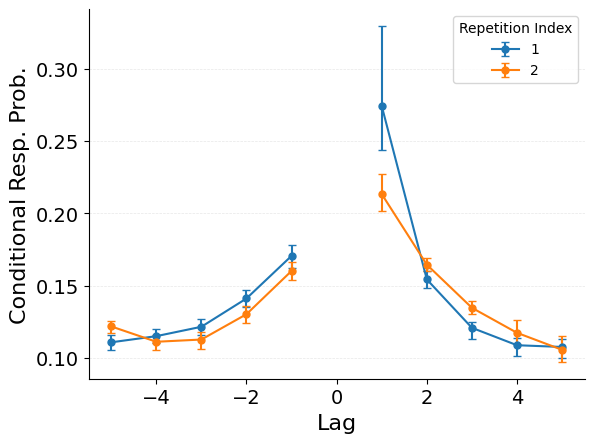

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_back_rep_crp.png)


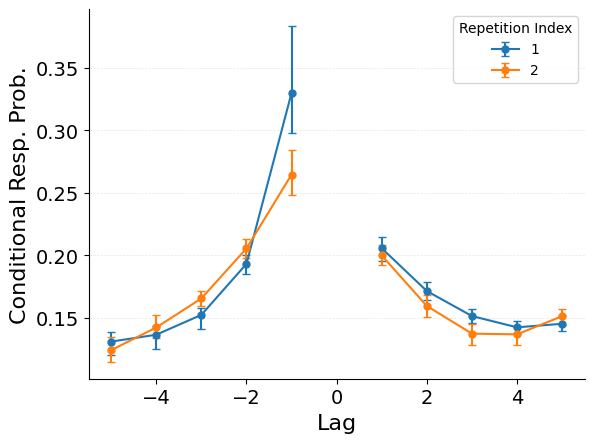

In [7]:
#|code-summary: single-dataset views

for analysis in single_analyses:
    figure_str = f"{data_tag}_{model_name}_{run_tag}_{analysis.__name__[5:]}.png"
    figure_path = os.path.join(product_dirs["figures"], figure_str)
    print(f"![]({figure_path})")

    # if redo_figures, check if figure already exists and don't redo
    # we want to display the figure here if it already exists
    if os.path.exists(figure_path) and not redo_figures:
        display(Image(filename=figure_path))
    else:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

        # Create a mask for data using np.isin for the selected list types
        trial_mask = generate_trial_mask(sim, trial_query)

        axis = analysis(
            datasets=[sim],
            trial_masks=[np.array(trial_mask)],
            color_cycle=color_cycle,
            labels=["First", "Second"],
            contrast_name="Repetition Index",
            axis=None,
            distances=None,
        )

        plt.savefig(figure_path, bbox_inches="tight", dpi=600)
        plt.show()

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_spc.png)


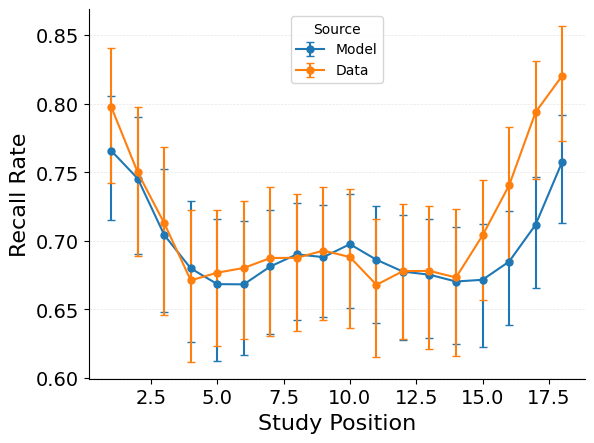

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_crp.png)


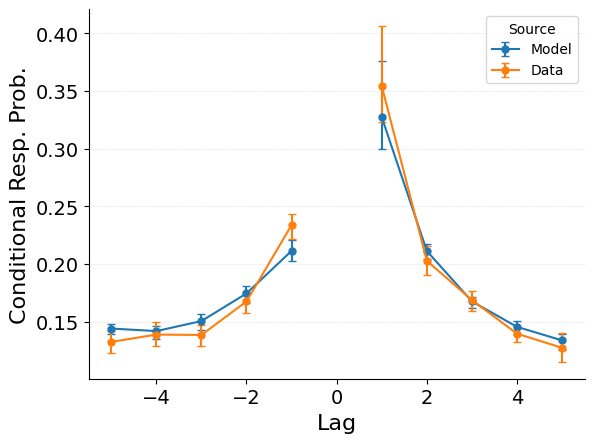

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_pnr.png)


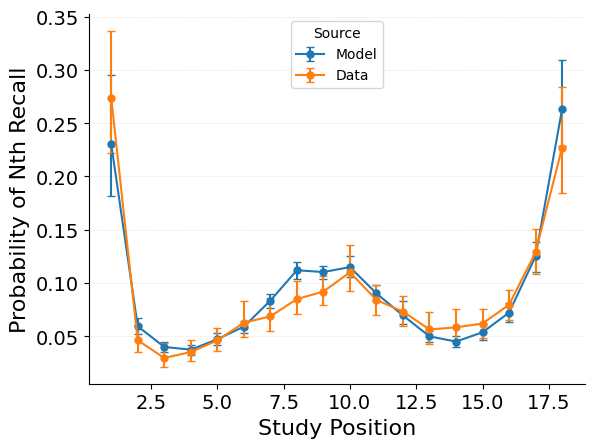

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_repneighborcrp_i2j.png)


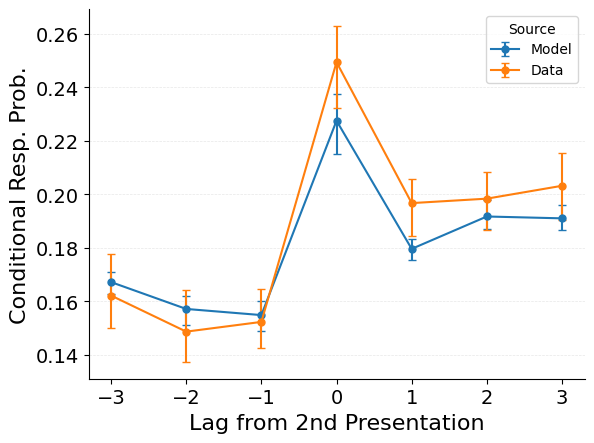

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_repneighborcrp_j2i.png)


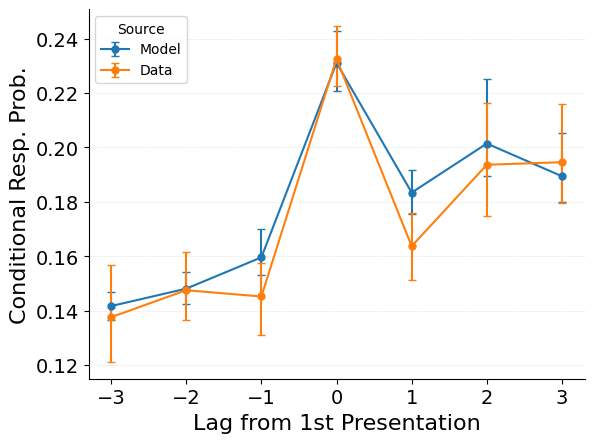

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_repneighborcrp_both.png)


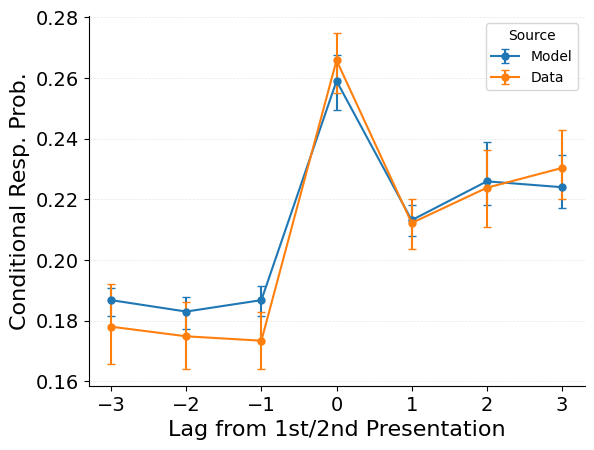

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_rpl.png)


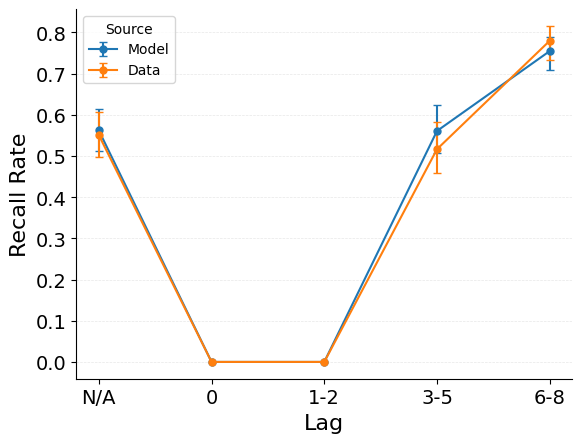

![](projects/thesis/figures/BroitmanKahana2024_WeirdNoReinstateCMR_full_best_of_3_full_rpl.png)


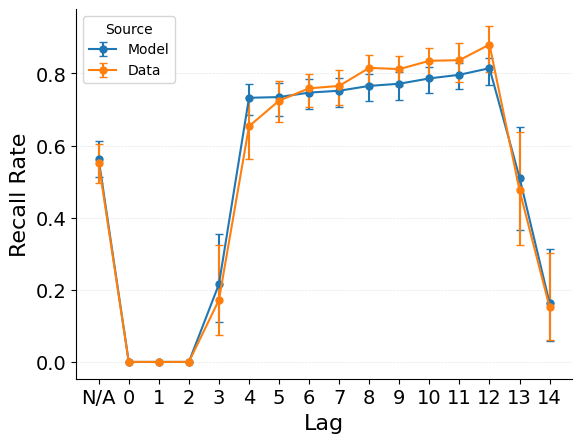

In [8]:
#| code-summary: mixed vs control views

for analysis in comparison_analyses:

    figure_str = f"{data_tag}_{model_name}_{run_tag}_{analysis.__name__[5:]}.png"
    figure_path = os.path.join(product_dirs["figures"], figure_str)
    print(f"![]({figure_path})")

    # if redo_figures, check if figure already exists and don't redo
    # we want to display the figure here if it already exists
    if os.path.exists(figure_path) and not redo_figures:
        display(Image(filename=figure_path))
        continue

    color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    # Create a mask for data using np.isin for the selected list types
    trial_mask = generate_trial_mask(data, trial_query)
    sim_trial_mask = generate_trial_mask(sim, trial_query)

    axis = analysis(
        datasets=[sim, data],
        trial_masks=[np.array(sim_trial_mask), np.array(trial_mask)],
        color_cycle=color_cycle,
        labels=["Model", "Data"],
        contrast_name="Source",
        axis=None,
        distances=None,
    )

    plt.savefig(figure_path, bbox_inches="tight", dpi=600)
    plt.show()